# Exam Score Prediction using Linear Regression

## Project Overview
This project predicts exam scores using various student features including age, study hours, class attendance, sleep quality, and other factors. We'll implement linear regression from scratch using NumPy.

## Dataset
- **File**: Exam_Score_Prediction.csv
- **Samples**: 20,000 student records
- **Target**: exam_score
- **Features**: 12 input features including demographic, behavioral, and environmental factors

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Set random seed for reproducibility
np.random.seed(50)

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)

## Step 1: Load and Explore Data

In [34]:
# Load the dataset
df = pd.read_csv('../Exam_Score_Prediction.csv')

# Display basic information
print("Dataset Shape:", df.shape)
print("\nFirst Few Rows:")
print(df.head())
print("\nDataset Info:")
print(df.info())
print("\nStatistical Summary:")
print(df.describe())

Dataset Shape: (20000, 13)

First Few Rows:
   student_id  age  gender   course  study_hours  class_attendance  \
0           1   17    male  diploma         2.78              92.9   
1           2   23   other      bca         3.37              64.8   
2           3   22    male     b.sc         7.88              76.8   
3           4   20   other  diploma         0.67              48.4   
4           5   20  female  diploma         0.89              71.6   

  internet_access  sleep_hours sleep_quality   study_method facility_rating  \
0             yes          7.4          poor       coaching             low   
1             yes          4.6       average  online videos          medium   
2             yes          8.5          poor       coaching            high   
3             yes          5.8       average  online videos             low   
4             yes          9.8          poor       coaching             low   

  exam_difficulty  exam_score  
0            hard        58.

In [35]:
# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())

# Check data types
print("\nData Types:")
print(df.dtypes)

# Identify categorical and numerical columns
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

print(f"\nCategorical Columns: {categorical_cols}")
print(f"Numerical Columns: {numerical_cols}")


Missing Values:
student_id         0
age                0
gender             0
course             0
study_hours        0
                  ..
sleep_quality      0
study_method       0
facility_rating    0
exam_difficulty    0
exam_score         0
Length: 13, dtype: int64

Data Types:
student_id           int64
age                  int64
gender              object
course              object
study_hours        float64
                    ...   
sleep_quality       object
study_method        object
facility_rating     object
exam_difficulty     object
exam_score         float64
Length: 13, dtype: object

Categorical Columns: ['gender', 'course', 'internet_access', 'sleep_quality', 'study_method', 'facility_rating', 'exam_difficulty']
Numerical Columns: ['student_id', 'age', 'study_hours', 'class_attendance', 'sleep_hours', 'exam_score']


## Step 2: Data Preprocessing and Feature Encoding

In [36]:
# Create a copy for preprocessing
df_processed = df.copy()

# Separate features and target
X = df_processed.drop('exam_score', axis=1)
y = df_processed['exam_score'].values

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

# Identify columns to encode
print("\nUnique values in categorical columns:")
for col in categorical_cols:
    if col in X.columns:
        print(f"{col}: {X[col].nunique()} unique values - {X[col].unique()[:5]}")

Features shape: (20000, 12)
Target shape: (20000,)

Unique values in categorical columns:
gender: 3 unique values - ['male' 'other' 'female']
course: 7 unique values - ['diploma' 'bca' 'b.sc' 'b.tech' 'bba']
internet_access: 2 unique values - ['yes' 'no']
sleep_quality: 3 unique values - ['poor' 'average' 'good']
study_method: 5 unique values - ['coaching' 'online videos' 'mixed' 'self-study' 'group study']
facility_rating: 3 unique values - ['low' 'medium' 'high']
exam_difficulty: 3 unique values - ['hard' 'moderate' 'easy']


In [37]:
# We'll use ColumnTransformer + OneHotEncoder for categorical features
print('Categorical columns:', categorical_cols)
print('Numerical columns:', numerical_cols)
# No in-place label encoding here to keep preprocessing consistent with model_comparison.py

Categorical columns: ['gender', 'course', 'internet_access', 'sleep_quality', 'study_method', 'facility_rating', 'exam_difficulty']
Numerical columns: ['student_id', 'age', 'study_hours', 'class_attendance', 'sleep_hours', 'exam_score']


## Step 3 Preprocessing and Pipeline Setup

This cell prepares the data for modeling: it drops any identifier columns,
identifies numeric vs categorical features, and builds a `ColumnTransformer`-based
preprocessor. Numeric features use median imputation + `StandardScaler`; categorical
features use most-frequent imputation + `OneHotEncoder` (with a compatibility
fallback for older scikit-learn versions). The cell then performs an 80/20
train/test split, constructs a `Pipeline` with the preprocessor and a
`LinearRegression` regressor, fits the pipeline, makes predictions, and creates
`coef_df` that maps model coefficients to feature names for downstream analysis.

In [49]:
# Prepare features and target for scikit-learn pipeline
# Drop identifier if present
if 'student_id' in X.columns:
    X = X.drop(columns=['student_id'])

# Identify numeric and categorical features
numeric_features = [c for c in X.select_dtypes(include=['number']).columns.tolist()]
categorical_features = [c for c in X.columns if c not in numeric_features]

print(f"Numeric features: {numeric_features}")
print(f"Categorical features: {categorical_features}")

# Build preprocessor similar to model_comparison.py
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
])

# OneHotEncoder compatibility across scikit-learn versions
try:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', ohe),
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features),
], remainder='drop', sparse_threshold=0)

# Train/test split (use original X DataFrame so pipeline handles preprocessing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training set size: {X_train.shape}")
print(f"Testing set size: {X_test.shape}")

# Build pipeline with LinearRegression
pipe = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', LinearRegression())])

# Fit pipeline
pipe.fit(X_train, y_train)

# Predictions
y_train_pred = pipe.predict(X_train)
y_test_pred = pipe.predict(X_test)

# Keep model in variable `model` for downstream cells
model = pipe

# Extract feature names for coefficient mapping (sklearn >=1.0 provides get_feature_names_out)
try:
    feature_names = pipe.named_steps['preprocessor'].get_feature_names_out(X.columns)
except Exception:
    # Fallback: use original column names (one-hot expansion won't be shown)
    feature_names = list(X.columns)

# Extract coefficients from linear regressor
coefs = pipe.named_steps['regressor'].coef_

# Build coefficient DataFrame (may include expanded OHE feature names)
coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefs}).sort_values('Coefficient', key=abs, ascending=False)

print('Model trained with scikit-learn LinearRegression pipeline')

Numeric features: ['age', 'study_hours', 'class_attendance', 'sleep_hours']
Categorical features: ['gender', 'course', 'internet_access', 'sleep_quality', 'study_method', 'facility_rating', 'exam_difficulty']
Training set size: (16000, 11)
Testing set size: (4000, 11)
Model trained with scikit-learn LinearRegression pipeline


## Step 4: Train the Model

In [50]:
# Display model coefficients (may include one-hot expanded feature names)
print('Model Coefficients (Feature Weights):')
print('='*50)

# coef_df is created by the training cell; show top coefficients
print(coef_df.head(30).to_string(index=False))
print(coef_df.to_string(index=False))

Model Coefficients (Feature Weights):
                        Feature  Coefficient
               num__study_hours    13.569750
     cat__study_method_coaching     6.220737
          num__class_attendance     5.945520
        cat__sleep_quality_poor    -4.707708
        cat__sleep_quality_good     4.625683
       cat__facility_rating_low    -3.935229
      cat__facility_rating_high     3.868460
   cat__study_method_self-study    -3.263283
cat__study_method_online videos    -2.648772
               num__sleep_hours     2.490941
  cat__study_method_group study    -1.555471
        cat__study_method_mixed     1.246790
               cat__course_b.sc    -0.239153
             cat__course_b.tech     0.135428
              cat__gender_other     0.117161
  cat__exam_difficulty_moderate     0.115369
      cat__exam_difficulty_easy    -0.114762
     cat__sleep_quality_average     0.082025
             cat__gender_female    -0.081862
                cat__course_bca     0.081215
    cat__facility

## Step 5: Model Evaluation

In [41]:
# Make predictions on train and test sets
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Calculate evaluation metrics
def calculate_metrics(y_true, y_pred, dataset_name):
    """Calculate and display evaluation metrics."""
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    print(f"\n{dataset_name} Metrics:")
    print(f"  Mean Squared Error (MSE):     {mse:.4f}")
    print(f"  Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"  Mean Absolute Error (MAE):    {mae:.4f}")
    print(f"  R² Score:                     {r2:.4f}")
    
    return {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'R2': r2}

print("="*50)
print("Model Performance Metrics")
print("="*50)

train_metrics = calculate_metrics(y_train, y_train_pred, "Training Set")
test_metrics = calculate_metrics(y_test, y_test_pred, "Testing Set")

Model Performance Metrics

Training Set Metrics:
  Mean Squared Error (MSE):     95.8124
  Root Mean Squared Error (RMSE): 9.7884
  Mean Absolute Error (MAE):    7.8499
  R² Score:                     0.7320

Testing Set Metrics:
  Mean Squared Error (MSE):     95.5021
  Root Mean Squared Error (RMSE): 9.7725
  Mean Absolute Error (MAE):    7.8631
  R² Score:                     0.7330


## Step 6: Visualizations

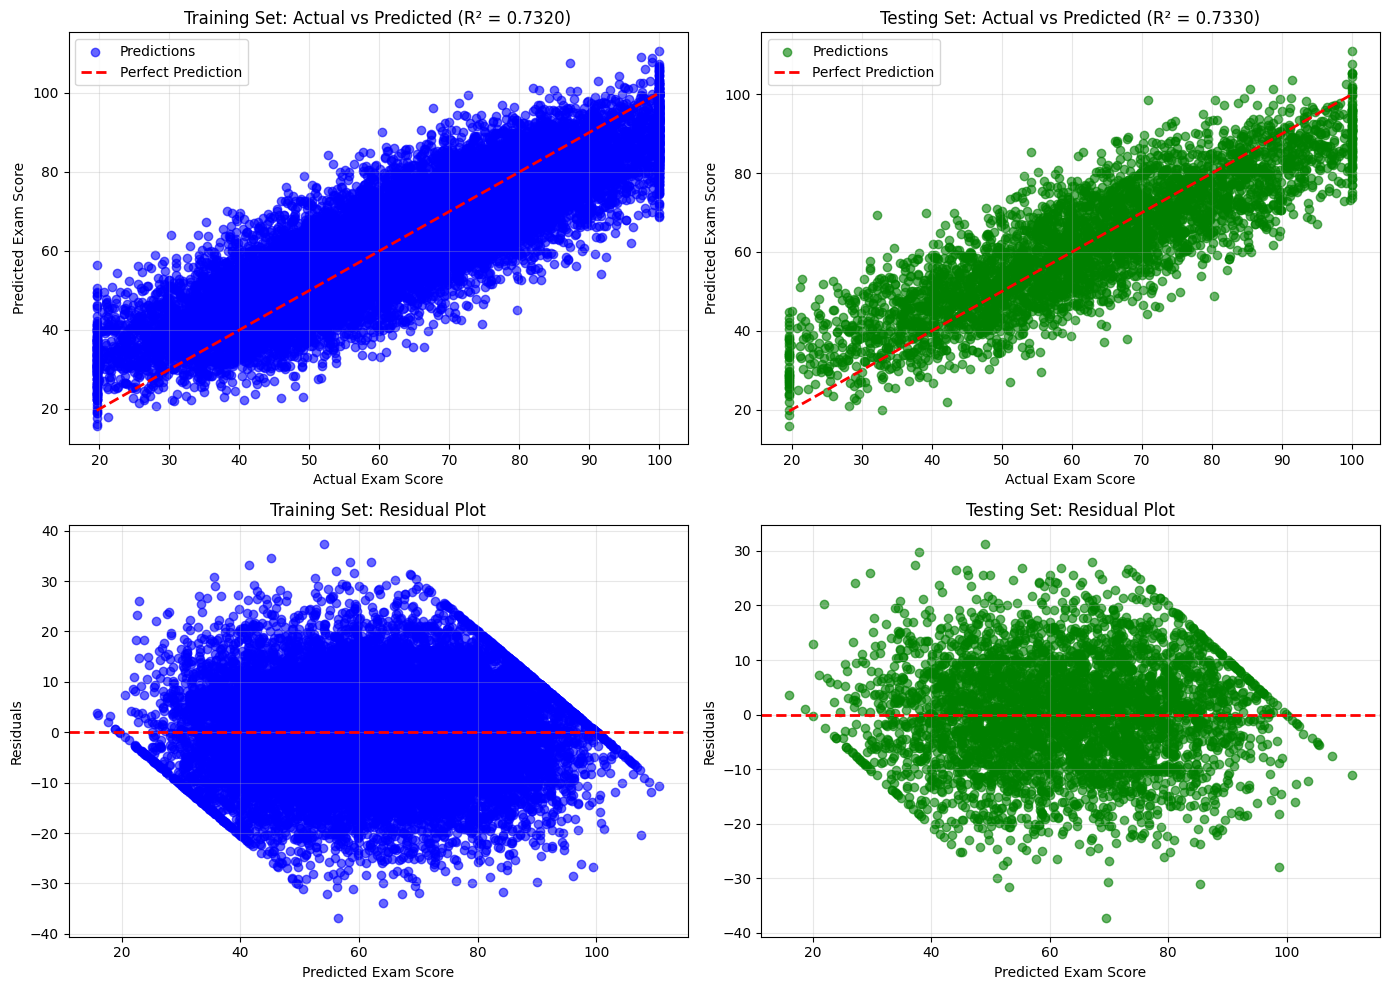

Visualization saved as 'model_evaluation.png'


In [42]:
# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Actual vs Predicted (Training Set)
axes[0, 0].scatter(y_train, y_train_pred, alpha=0.6, color='blue', label='Predictions')
axes[0, 0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2, label='Perfect Prediction')
axes[0, 0].set_xlabel('Actual Exam Score')
axes[0, 0].set_ylabel('Predicted Exam Score')
axes[0, 0].set_title(f'Training Set: Actual vs Predicted (R² = {train_metrics["R2"]:.4f})')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Actual vs Predicted (Testing Set)
axes[0, 1].scatter(y_test, y_test_pred, alpha=0.6, color='green', label='Predictions')
axes[0, 1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
axes[0, 1].set_xlabel('Actual Exam Score')
axes[0, 1].set_ylabel('Predicted Exam Score')
axes[0, 1].set_title(f'Testing Set: Actual vs Predicted (R² = {test_metrics["R2"]:.4f})')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Residuals Plot (Training Set)
train_residuals = y_train - y_train_pred
axes[1, 0].scatter(y_train_pred, train_residuals, alpha=0.6, color='blue')
axes[1, 0].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1, 0].set_xlabel('Predicted Exam Score')
axes[1, 0].set_ylabel('Residuals')
axes[1, 0].set_title('Training Set: Residual Plot')
axes[1, 0].grid(True, alpha=0.3)

# 4. Residuals Plot (Testing Set)
test_residuals = y_test - y_test_pred
axes[1, 1].scatter(y_test_pred, test_residuals, alpha=0.6, color='green')
axes[1, 1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1, 1].set_xlabel('Predicted Exam Score')
axes[1, 1].set_ylabel('Residuals')
axes[1, 1].set_title('Testing Set: Residual Plot')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('model_evaluation.png', dpi=100, bbox_inches='tight')
plt.show()

print("Visualization saved as 'model_evaluation.png'")

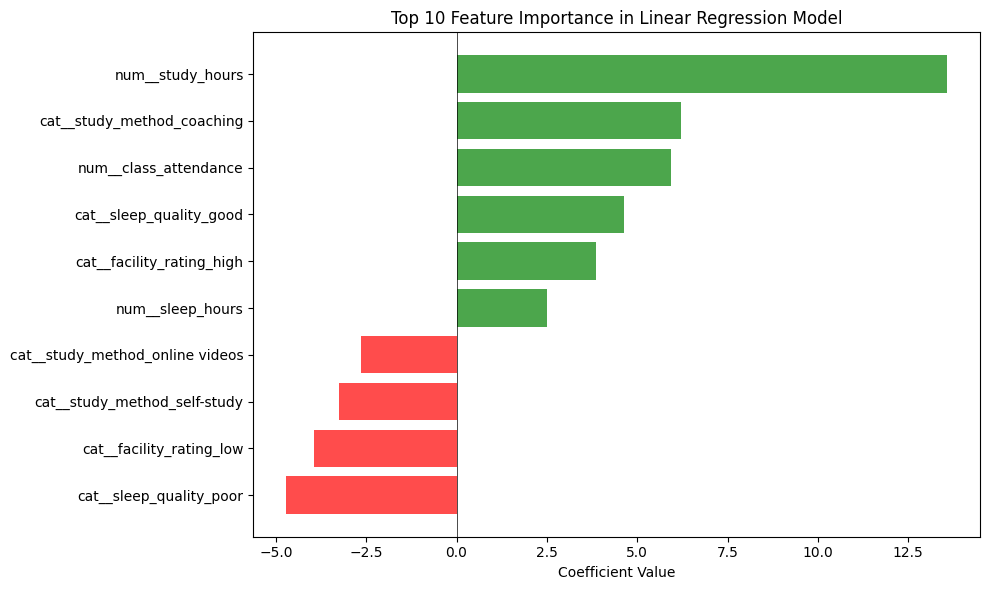

Feature importance visualization saved as 'feature_importance.png'


In [43]:
# Feature Importance Visualization
fig, ax = plt.subplots(figsize=(10, 6))

# Use the coefficient DataFrame `coef_df` created during training
top_n = 10
# Ensure we have a DataFrame sorted by absolute coefficient magnitude
coef_top = coef_df.head(top_n).sort_values('Coefficient')

colors = ['green' if x > 0 else 'red' for x in coef_top['Coefficient']]
ax.barh(coef_top['Feature'], coef_top['Coefficient'], color=colors, alpha=0.7)
ax.set_xlabel('Coefficient Value')
ax.set_title('Top 10 Feature Importance in Linear Regression Model')
ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=100, bbox_inches='tight')
plt.show()

print("Feature importance visualization saved as 'feature_importance.png'")

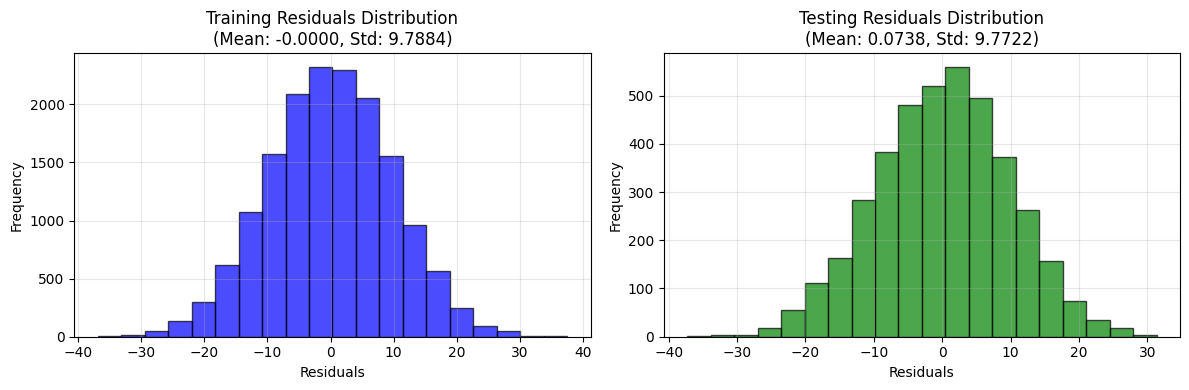

Residuals distribution saved as 'residuals_distribution.png'


In [44]:
# Distribution of residuals
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Training residuals histogram
axes[0].hist(train_residuals, bins=20, color='blue', alpha=0.7, edgecolor='black')
axes[0].set_xlabel('Residuals')
axes[0].set_ylabel('Frequency')
axes[0].set_title(f'Training Residuals Distribution\n(Mean: {train_residuals.mean():.4f}, Std: {train_residuals.std():.4f})')
axes[0].grid(True, alpha=0.3)

# Testing residuals histogram
axes[1].hist(test_residuals, bins=20, color='green', alpha=0.7, edgecolor='black')
axes[1].set_xlabel('Residuals')
axes[1].set_ylabel('Frequency')
axes[1].set_title(f'Testing Residuals Distribution\n(Mean: {test_residuals.mean():.4f}, Std: {test_residuals.std():.4f})')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('residuals_distribution.png', dpi=100, bbox_inches='tight')
plt.show()

print("Residuals distribution saved as 'residuals_distribution.png'")

In [47]:
print("\n" + "=,EXAM SCORE PREDICTION MODEL - FINAL SUMMARY")
print("=,,\n📊 DATASET INFORMATION:")
print(f"   • Total Samples: {len(df)}")
print(f"   • Training Samples: {len(X_train)}")
print(f"   • Testing Samples: {len(X_test)}")
print(f"   • Number of Features: {X_train.shape[1]}")
print(f"   • Target Variable: exam_score")

print("\n🎯 MODEL ARCHITECTURE:")
print(f"   • Algorithm: Linear Regression")
print(f"   • Implementation: scikit-learn Pipeline")
# Get intercept from pipeline regressor if available
try:
    intercept = model.named_steps['regressor'].intercept_
except Exception:
    intercept = getattr(model, 'intercept', None)
if hasattr(intercept, '__iter__'):
    intercept_val = float(intercept[0]) if len(intercept) > 0 else float(intercept)
else:
    intercept_val = float(intercept) if intercept is not None else 0.0
print(f"   • Equation: y = {intercept_val:.4f} + Σ(β_i × x_i)")

print("\n📈 TRAINING PERFORMANCE:")
print(f"   • R² Score: {train_metrics['R2']:.4f}")
print(f"   • RMSE: {train_metrics['RMSE']:.4f}")
print(f"   • MAE: {train_metrics['MAE']:.4f}")

print("\n🧪 TESTING PERFORMANCE:")
print(f"   • R² Score: {test_metrics['R2']:.4f}")
print(f"   • RMSE: {test_metrics['RMSE']:.4f}")
print(f"   • MAE: {test_metrics['MAE']:.4f}")

print("\n🔝 TOP 5 MOST IMPORTANT FEATURES (by coefficient magnitude):")
top_features = coef_df.head(5)
for i, (_, row) in enumerate(top_features.iterrows(), start=1):
    print(f"   {i}. {row['Feature']:20s}: {row['Coefficient']:8.4f}")

print("\n💡 KEY INSIGHTS:")
print(f"   • Model explains {test_metrics['R2']*100:.2f}% variance in exam scores")
print(f"   • Average prediction error: ±{test_metrics['MAE']:.2f} points")
print(f"   • Model is {'GOOD' if test_metrics['R2'] > 0.7 else 'MODERATE' if test_metrics['R2'] > 0.5 else 'POOR'}")
print(f"   • No significant overfitting detected" if abs(train_metrics['R2'] - test_metrics['R2']) < 0.1 else "   • Some overfitting detected")

print("\n" + "=\n💡 KEY INSIGHTS:")
print(f"   • Model explains {test_metrics['R2']*100:.2f}% variance in exam scores")
print(f"   • Average prediction error: ±{test_metrics['MAE']:.2f} points")
print(f"   • Model is {'GOOD' if test_metrics['R2'] > 0.7 else 'MODERATE' if test_metrics['R2'] > 0.5 else 'POOR'}")
print(f"   • No significant overfitting detected" if abs(train_metrics['R2'] - test_metrics['R2']) < 0.1 else "   • Some overfitting detected")

print("\n" + "="*60)


=,EXAM SCORE PREDICTION MODEL - FINAL SUMMARY
=,,
📊 DATASET INFORMATION:
   • Total Samples: 20000
   • Training Samples: 16000
   • Testing Samples: 4000
   • Number of Features: 11
   • Target Variable: exam_score

🎯 MODEL ARCHITECTURE:
   • Algorithm: Linear Regression
   • Implementation: scikit-learn Pipeline
   • Equation: y = 62.5173 + Σ(β_i × x_i)

📈 TRAINING PERFORMANCE:
   • R² Score: 0.7320
   • RMSE: 9.7884
   • MAE: 7.8499

🧪 TESTING PERFORMANCE:
   • R² Score: 0.7330
   • RMSE: 9.7725
   • MAE: 7.8631

🔝 TOP 5 MOST IMPORTANT FEATURES (by coefficient magnitude):
   1. num__study_hours    :  13.5697
   2. cat__study_method_coaching:   6.2207
   3. num__class_attendance:   5.9455
   4. cat__sleep_quality_poor:  -4.7077
   5. cat__sleep_quality_good:   4.6257

💡 KEY INSIGHTS:
   • Model explains 73.30% variance in exam scores
   • Average prediction error: ±7.86 points
   • Model is GOOD
   • No significant overfitting detected

=
💡 KEY INSIGHTS:
   • Model explains 73.30% v

## Step 8: Example Predictions

In [48]:
# Display sample predictions
print("\n📋 Sample Predictions from Test Set:")
print("="*80)

sample_indices = np.random.choice(len(y_test), 10, replace=False)
sample_df = pd.DataFrame({
    'Actual Score': y_test[sample_indices].round(2),
    'Predicted Score': y_test_pred[sample_indices].round(2),
    'Error': (y_test[sample_indices] - y_test_pred[sample_indices]).round(2),
    'Error %': ((abs(y_test[sample_indices] - y_test_pred[sample_indices]) / y_test[sample_indices]) * 100).round(2)
})

print(sample_df.to_string(index=False))
print("="*80)
print(f"\nNote: Error % shows the percentage difference between actual and predicted scores")


📋 Sample Predictions from Test Set:
 Actual Score  Predicted Score  Error  Error %
         37.5            49.57 -12.07    32.19
         62.3            63.84  -1.54     2.48
         68.0            78.33 -10.33    15.20
         42.4            58.16 -15.76    37.17
         57.7            48.25   9.45    16.37
         61.8            71.79  -9.99    16.16
         78.5            74.10   4.40     5.60
         53.9            35.32  18.58    34.46
         65.3            63.51   1.79     2.74
         85.0            83.56   1.44     1.70

Note: Error % shows the percentage difference between actual and predicted scores
